# Using this chapter’s housing dataset:

## Preparing Data

Read the Data with Pandas

In [ ]:
import pandas as pd

housing_csv = 'https://github.com/lucaslokchan/ml-journal/raw/master/Learning%20Notes/Chapter%202:%20End-to-End%20Machine%20Learning%20Project/housing.csv'
housing = pd.read_csv(housing_csv)

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Divide Median Income Into 5 Categories

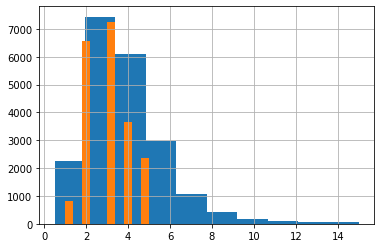

In [ ]:
import numpy as np
housing['median_income'].hist()
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing['income_cat'].hist()

Perform Stratified Sampling Based on the Income Category

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

Prepare the data for your Machine Learning algorithms

In [ ]:
housing = strat_train_set.copy()
housing_labels =strat_train_set['median_house_value'].copy()

Get Rid of ocean_proximity (Non-Numerical Attribute) Since the Median can Only be Computer on Numerical Attributes

In [ ]:
housing_num = housing.drop('ocean_proximity', axis=1)

Data Cleaning Pipeline
*   Transform Number Attributes 
*   Convert ocean_proximity with OneHotEncoder



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),    
        ('std_scaler', StandardScaler()),  
])

full_pipeline = ColumnTransformer([
          ('num', num_pipeline, num_attribs),
          ('cat', OneHotEncoder(), cat_attribs),
])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
housing_prepared.shape

(16512, 15)

## 1. Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform? 

In [ ]:
from sklearn.svm import SVR

sv_reg = SVR()
sv_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Measure this regression model’s RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = sv_reg.predict(housing_prepared)
sv_mse = mean_squared_error(housing_labels, housing_predictions)
sv_rmse = np.sqrt(sv_mse)
sv_rmse

117881.41045362344

## 2. Try replacing GridSearchCV with RandomizedSearchCV 

## 3. Try adding a transformer in the preparation pipeline to select only the most important attributes.

## 4. Try creating a single pipeline that does the full data preparation plus the final prediction.

## 5. Automatically explore some preparation options using GridSearchCV